In [127]:
include("covid-19-model.jl")
##############################################
# Parameters
##############################################

β, μ, α = 1.0, 0.8, .1
D, Z  = 4, 4 # Days
N = 1.0
default_parameters=[β, μ, α, D, Z]

r₀=1.
r=.1
ϵ = .1
tol = 1e-3
#solver = optimizer_with_attributes(CSDP.Optimizer, "printlevel" => 0)
solver = optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)
@show solver

##############################################
# Vector Field
##############################################

function transmission_vf(S, E, Ir, Iu;
    parameters=default_parameters)
    β, μ, α, D, Z = parameters
    [
        - β * S/N * Ir - μ * β * S/N * Iu,
          β * S/N * Ir + μ * β * S/N * Iu - E/Z,
        α * E/Z - Ir/D,
        (1-α) * E/Z - Iu/D
    ]
end



solver = MathOptInterface.OptimizerWithAttributes(Mosek.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute,Any}[RawParameter("QUIET")=>true])
solver = MathOptInterface.OptimizerWithAttributes(Mosek.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute,Any}[RawParameter("QUIET")=>true])


transmission_vf (generic function with 2 methods)

# Solve using ODE solver

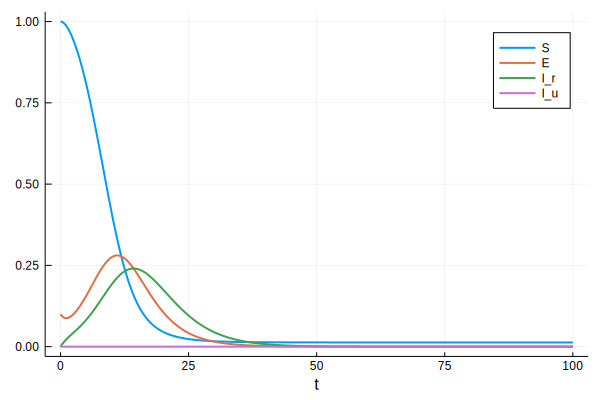

In [128]:
function vf_for_solver(dx, x, params, t)
        dx[1], dx[2], dx[3], dx[4] = transmission_vf(x..., parameters=params)
end

# S, E, Ir, Iu
u0 = [1., .1, .0, .0]
tspan = (0.0, 100.0)
prob = ODEProblem(vf_for_solver,u0,tspan, params)
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

ts = tspan[1]:.1:tspan[2]
sol_sampled = sol(ts)
sol_sampled = hcat(sol_sampled.u...)
label=["S" "E" "I_r" "I_u"]

plot(ts, sol_sampled', label=label, linewidth=2, xaxis="t")

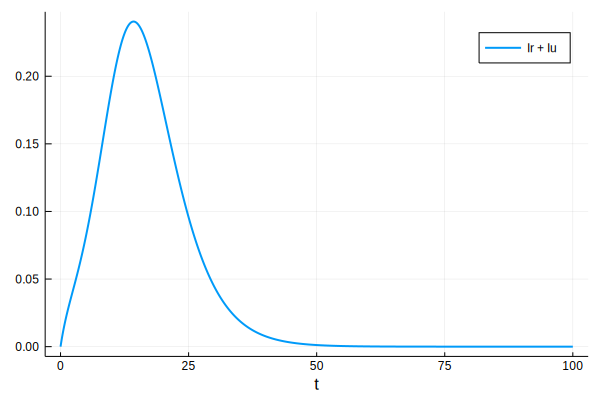

In [129]:
plot(ts, sol_sampled[3, :]+sol_sampled[4, :], label="Ir + Iu", linewidth=2, xaxis="t")

# Effect of larger $\alpha$

In [131]:
α = .1
β = 1.0
μ = 0.8
D, Z  = 4, 4 # Days
N = 1.0



# S, E, Ir, Iu
u0 = [1., .1, .0, .0]


tspan = (0.0, 100.0)

αs = 0:.\01:1
max_infected_people = zeros(size(αs))
for (i,α)=enumerate(αs)
    params=[β, μ, α, D, Z]
    prob = ODEProblem(vf_for_solver,u0,tspan, params)
    sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    ts = tspan[1]:.1:tspan[2]
    sol_sampled = sol(ts)
    sol_sampled = hcat(sol_sampled.u...)

    total_infected_people = sol_sampled[3, :]+sol_sampled[4, :]
    max_infected_people[i] = maximum(total_infected_people)
end
plot(αs, max_infected_people, label="max(Ir + Iu)", linewidth=2, xaxis="\$\\alpha\$")


LoadError: syntax: ".\" is not a unary operator

In [101]:
maximum(total_infected_people)

0.2091027172510134